# Exercise 1

(yield curve) Use the results from Exercise 3 last week

    a. Plot the yield curve. Does something look odd? If so, what?
    b. Calculate the Nelson-Siegel coefficients and fitted interest rates
    c. Plot the the Nelson-Siegel fitted yield curve in the same plot as before and
    compare
    
**Note:** You may have to remove some of the bonds from your data before computing the Nelson-Siegel coefficients.


Data collected manually from the website 'http://www.nasdaqomxnordic.com/bonds/denmark' on 2021-09-15


Part a
Cash flow for the bonds:

            1,5St.l.23 GB  3St.l. 21 GB  4,5 St.l 39 GB  7 St.l 24 GB  \
2021-09-15    -105.569315    -103.10863     -181.707945   -130.130137   
2021-11-15       1.500000     103.00000        4.500000      7.000000   
2022-11-15       1.500000       0.00000        4.500000      7.000000   
2023-11-15     101.500000       0.00000        4.500000      7.000000   
2024-11-15       0.000000       0.00000        4.500000    107.000000   
2025-11-15       0.000000       0.00000        4.500000      0.000000   
2026-11-15       0.000000       0.00000        4.500000      0.000000   
2027-11-15       0.000000       0.00000        4.500000      0.000000   
2028-11-15       0.000000       0.00000        4.500000      0.000000   
2029-11-15       0.000000       0.00000        4.500000      0.000000   
2030-11-15       0.000000       0.00000        4.500000     

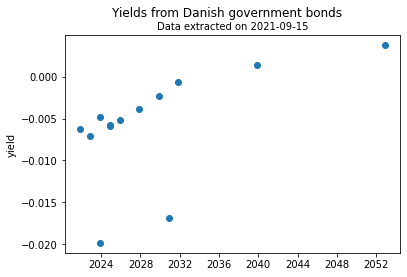

In [5]:
#### FROM EXERCISE SOLUTION ####

import matplotlib.pyplot as plt, pandas as pd, datetime, numpy as np, scipy.optimize as optimize

start_date_str = '2021-09-15'

print("Data collected manually from the website 'http://www.nasdaqomxnordic.com/bonds/denmark' on " +
		start_date_str + '\n')

start_date = datetime.datetime.fromisoformat(start_date_str)
last_coupon_date = datetime.datetime.fromisoformat('2020-11-15')

dict_bonds = {'Bond':['1,5St.l.23 GB', '3St.l. 21 GB', '4,5 St.l 39 GB', '7 St.l 24 GB',
						'DANSKE STAT 2022', 'DANSKE STAT 2029', 'DGBI 2023 GB', 'DGBi',
						'Danske Stat 2024', 'Danske Stat 2025', 'Danske Stat 2027',
						'Danske Stat 2031', 'Danske Stat 2052'],
         	 'Price':[104.32,100.61,177.96,124.3,101.12,105.99,104.67,117.95,
         	 			101.88, 109.56, 105.51, 100.57, 96.23],
         	 'Coupon':[1.50,3.00,4.50,7.00,0.25,0.50,0.10,0.10,0.00,1.75,0.50,0.00,0.25],
         	 'MatYear':[2023,2021,2039,2024,2022,2029,2023,2030,2024,2025,2027,2031,2052]}

# Part 3a
print('\nPart a')

bonds = pd.DataFrame(dict_bonds)
bonds.set_index('Bond', inplace=True)

bonds['MatDate'] = bonds['MatYear'].apply(lambda x: datetime.datetime(x,11,15))
bonds['DirtyPrice'] = bonds['Price'] + bonds['Coupon']*(start_date-last_coupon_date).days/365

# Create list of times for the cash flow
times = list(range(start_date.year,max(dict_bonds['MatYear'])+1))
times = [datetime.datetime(x,11,15) for x in times]
times.insert(0,start_date)

# Create the dirty cash flow
CFdirty = pd.DataFrame(0, index=dict_bonds['Bond'], columns=times)
# Insert the dirty price
CFdirty[times[0]] = -bonds['DirtyPrice']
# Insert coupons and PAR
for i in range(1,len(times)):
	CFdirty[times[i]] = bonds['Coupon']*(times[i].year<=bonds['MatYear']) + 100*(times[i].year==bonds['MatYear'])

print('Cash flow for the bonds:\n')
print(CFdirty.transpose())

# Part 3b
print('\nPart b')

# Get time since start
time_since_start = pd.DataFrame(np.NaN, index=times, columns=['t'])
for t in times:
	time_since_start['t'][t] = (t-start_date).days/365

# Calculate the yield to maturity
YtM = pd.DataFrame(np.NaN, index=dict_bonds['Bond'], columns=['T', 'YtM'])
YtM['T'] = bonds['MatDate']

def calculate_absdiff(r):
	value = 0
	for t in times[1:]:
		value += CFdirty[t][bond]*(1+r)**-time_since_start['t'][t]
	return abs(value+CFdirty[times[0]][bond])

for bond in dict_bonds['Bond']:
	YtM.loc[bond, 'YtM'] = optimize.newton(calculate_absdiff, -0.01, tol=1e-10, maxiter=100)

print('Yield to maturity')
print(YtM)

# Part 3c
print('\nPart c')
print('Visualize yields')
# To avoid future warning deregister mpl converters
from pandas.plotting import deregister_matplotlib_converters
deregister_matplotlib_converters()

plt.scatter(YtM['T'], YtM['YtM'])
plt.suptitle('Yields from Danish government bonds')
plt.title('Data extracted on ' + start_date_str, fontsize=10)
plt.ylabel('yield')
plt.show()

### Plot the yield curve. Does something look odd? If so, what?



The points .....

In [ ]:
#TESSSST

# Exercise 2 

(duration, convexity) Use the results from Exercise 3 last week.

    a. Compute the Macaulay duration and the modified duration for all bonds
    b. Compute the convexity for all bonds
    c. Compute Fisher-Weil durations and convexities using the obtained term
    structure model from Question 1

# Exercise 3

In this task you play the role of bond portfolio manager. A client would like to invest in Danish Government bonds. He asks you to invest DKK 1.000.000 in a portfolio of bonds and wants you to assess the risk of holding this portfolio.

    a. The portfolio calculations should be done using NASDAQ prices from a September-day on or after 
        September 15th. As there is little data in this project, I would not recommend you to 
        spend time on figuring out how to fetch data from the website automatically. 
        Just write them down in your scripts.
    b. Convert prices from clean to dirty or vice versa depending on your data.
    c. The term structure of interest rates should be done with a Nelson-Siegel term
        structure model fitted to all relevant government bond prices.
    d. Derive an expression for the duration of a portfolio of bonds and argue why you must 
        use the interest rates coming from the fitted term-structure model
        instead of rates obtained by calculating each bond's yield to maturity.
    e. Find a portfolio of three bonds with positive portfolio weights, such that the
        duration of the portfolio is X, where X = 5 + 0. 5 * (the digit sum of your
        student numbers).
    f. Using these weights, calculate the convexity of the portfolio as well as the
        value increase/decrease, if the interest rate curve shifts up by 1% (100bp).

**Note: For some bonds, there might be no recent trades and thereby prices for the day where you wish to do the analysis. In that case, you can for instance use the latest price.**